In [73]:
import pandas as pd
import os 
dirs = os.getcwd() 
files = os.listdir(dirs) 
files

['Impact of Brexit on the EU economy with Augmented Synthetic Control method.docx',
 '.ipynb_checkpoints',
 'Impact of Brexit thesis on the EU economy.ipynb',
 'Impact of Brexit on the EU economy with Augmented Synthetic Control method.pdf']

In [74]:
# Sources
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# https://nbviewer.jupyter.org/github/OscarEngelbrektson/SyntheticControlMethods/blob/master/examples/user_guide.ipynb

In [75]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import os 
from typing import List
from operator import add
from toolz import reduce, partial
from scipy import stats
from scipy.optimize import fmin_slsqp
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# read data file
# pandas read_csv

dirs = os.getcwd() 
files = os.listdir(dirs) 

data_c = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_GDP_CA_1.csv') 
data_c = data_c.loc[data_c.year >= 2006]
raw_data_c = copy.deepcopy(data_c)# Copy dataframe

data_g = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_Goods_eu_GDP_1.csv') 
data_g = data_g.loc[data_g.year >= 2006]
raw_data_g = copy.deepcopy(data_g)# Copy dataframe

data_s = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_Service_eu_GDP_1.csv') 
data_s = data_s.loc[data_s.year >= 2006]
raw_data_s = copy.deepcopy(data_s)# Copy dataframe

data_g_s = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_goods_service_eu_GDP_1.csv') 
data_g_s = data_g_s.loc[data_g_s.year >= 2006]
raw_data_g_s = copy.deepcopy(data_g_s)# Copy dataframe

data_primary = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_primary_income_eu_GDP_1.csv') 
data_primary = data_primary.loc[data_primary.year >= 2006]
raw_data_primary = copy.deepcopy(data_primary)# Copy dataframe

data_secondary = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_secondary_income_eu_GDP_1.csv') 
data_secondary = data_secondary.loc[data_secondary.year >= 2006]
raw_data_secondary = copy.deepcopy(data_secondary)# Copy dataframe



In [76]:
# Divide data by the year 2016 to check descriptive statistics

# raw_data_c.describe().loc[raw_data_c.country == 'EU'].to_excel('1ca.xlsx')
# raw_data_c.loc[raw_data_c.year <= 2016].loc[raw_data_c.country == 'EU'].describe().to_excel('1ca_before_e.xlsx')
# raw_data_c.loc[raw_data_c.year >  2016].loc[raw_data_c.country == 'EU'].describe().to_excel('1ca_after_e.xlsx')

# raw_data_g.describe().loc[raw_data_g.country == 'EU'].to_excel('1goods.xlsx')
# raw_data_g.loc[raw_data_g.year <= 2016].loc[raw_data_g.country == 'EU'].describe().to_excel('1g_before_e.xlsx')
# raw_data_g.loc[raw_data_g.year >  2016].loc[raw_data_g.country == 'EU'].describe().to_excel('1g_after_e.xlsx')

# raw_data_s.describe().loc[raw_data_s.country == 'EU'].to_excel('0service.xlsx')
# raw_data_s.loc[raw_data_s.year <= 2016].loc[raw_data_s.country == 'EU'].describe().to_excel('1s_before_e.xlsx')
# raw_data_s.loc[raw_data_s.year >  2016].loc[raw_data_s.country == 'EU'].describe().to_excel('1s_after_e.xlsx')

# raw_data_g_s.describe().loc[raw_data_g_s.country == 'EU'].to_excel('0gs.xlsx')
# raw_data_g_s.loc[raw_data_g_s.year <= 2016].loc[raw_data_g_s.country == 'EU'].describe().to_excel('1gs_before_e.xlsx')
# raw_data_g_s.loc[raw_data_g_s.year >  2016].loc[raw_data_g_s.country == 'EU'].describe().to_excel('1gs_after_e.xlsx')


# raw_data_primary.describe().loc[raw_data_primary.country == 'EU'].to_excel('0primary.xlsx')
# raw_data_primary.loc[raw_data_primary.year <= 2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1p_before_e.xlsx')
# raw_data_primary.loc[raw_data_primary.year >  2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1p_after_e.xlsx')

# raw_data_secondary.describe().loc[raw_data_primary.country == 'EU'].to_excel('0secondary.xlsx')
# raw_data_secondary.loc[raw_data_secondary.year <= 2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1se_before_e.xlsx')
# raw_data_secondary.loc[raw_data_secondary.year >  2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1se_after_e.xlsx')

In [77]:
display(data_g)

,country,year,Export of goods,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,913,...,9.912729,8.640000,11.042234
1,Brazil,2007,1114,...,9.912729,8.330000,12.918339
2,Brazil,2008,1677,...,9.912729,7.340000,14.265880
3,Brazil,2009,1759,...,9.912729,8.520000,7.168936
4,Brazil,2010,2169,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,142309,...,1.130620,9.150000,2.100000
131,EU,2017,163629,...,1.130620,8.158334,2.800000
132,EU,2018,172968,...,1.130620,7.283333,2.100000
133,EU,2019,170578,...,1.130620,6.716667,1.600000


In [78]:
display(data_s)

,country,year,Export of service,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,582,...,9.912729,8.640000,11.042234
1,Brazil,2007,548,...,9.912729,8.330000,12.918339
2,Brazil,2008,876,...,9.912729,7.340000,14.265880
3,Brazil,2009,811,...,9.912729,8.520000,7.168936
4,Brazil,2010,1109,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,103311,...,1.130620,9.150000,2.100000
131,EU,2017,114367,...,1.130620,8.158334,2.800000
132,EU,2018,125287,...,1.130620,7.283333,2.100000
133,EU,2019,120622,...,1.130620,6.716667,1.600000


In [79]:
display(data_g_s)

,country,year,Total exports of goods and services,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,1495,...,9.912729,8.640000,11.042234
1,Brazil,2007,1662,...,9.912729,8.330000,12.918339
2,Brazil,2008,2553,...,9.912729,7.340000,14.265880
3,Brazil,2009,2570,...,9.912729,8.520000,7.168936
4,Brazil,2010,3278,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,245620,...,1.130620,9.150000,2.100000
131,EU,2017,277996,...,1.130620,8.158334,2.800000
132,EU,2018,298255,...,1.130620,7.283333,2.100000
133,EU,2019,291200,...,1.130620,6.716667,1.600000


In [80]:
display(data_primary)

,country,year,Primary income,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,999,...,9.912729,8.640000,11.042234
1,Brazil,2007,1425,...,9.912729,8.330000,12.918339
2,Brazil,2008,1150,...,9.912729,7.340000,14.265880
3,Brazil,2009,1409,...,9.912729,8.520000,7.168936
4,Brazil,2010,2162,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,55619,...,1.130620,9.150000,2.100000
131,EU,2017,68304,...,1.130620,8.158334,2.800000
132,EU,2018,77832,...,1.130620,7.283333,2.100000
133,EU,2019,77993,...,1.130620,6.716667,1.600000


In [81]:
display(data_secondary)

,country,year,Secondary income,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,999,...,9.912729,8.640000,11.042234
1,Brazil,2007,1425,...,9.912729,8.330000,12.918339
2,Brazil,2008,1150,...,9.912729,7.340000,14.265880
3,Brazil,2009,1409,...,9.912729,8.520000,7.168936
4,Brazil,2010,2162,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,4599,...,1.130620,9.150000,2.100000
131,EU,2017,4597,...,1.130620,8.158334,2.800000
132,EU,2018,4675,...,1.130620,7.283333,2.100000
133,EU,2019,5169,...,1.130620,6.716667,1.600000


In [82]:
# Standardize independent variables
# mean 0 / variance 1

data_c[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_c[['inflation','education','unemployment rate','GDP growth rate']])

data_g[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_g [['inflation','education','unemployment rate','GDP growth rate']])

data_g[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_g_s[['inflation','education','unemployment rate','GDP growth rate']])

data_primary[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_primary[['inflation','education','unemployment rate','GDP growth rate']])

data_secondary[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_secondary[['inflation','education','unemployment rate','GDP growth rate']])



# 1. Raw data

In [83]:
def visulaize_origianl(country,interested_variable, data0):
  """
  Make graph with interested variable and country
  This function is to visulize the raw data 
  """

  # Make data0set that is only about entered country 
  str_expr = f"country == '{country}' " 
  data0_new = data0.query(str_expr) 

  plt.figure(figsize=(10,5)) 
  plt.plot(data0['year'],data0[interested_variable],marker="o",alpha=.6, label = f'{interested_variable} with Non {country}',color='dimgray')
  plt.plot(data0_new['year'],data0_new[interested_variable],label = f'{interested_variable} with {country}',color='black')   
  plt.vlines(x=2016,   ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.gray()
  plt.legend();  
  plt.show()


# 2. Synthetic Control Method

In [84]:
def X_y(country, main_variable, data0):
  """
   Get X and y
  """

  features = [ 'inflation',"education",'unemployment rate','GDP growth rate']

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values

  return X,y

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

def sythetic_weight(country, interested_variable, data0):   
  """
  Get the weight of synthetic control.
  """

  data_weights = get_w(X_y(country, interested_variable, data0)[0], X_y(country, interested_variable, data0)[1])
  print("Sum of weight:", data_weights.sum())

  return np.round(data_weights, 4)

def synthetic_control(country, main_variable, data0):
  """
  This function is to generate the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the synthetic controls of countries in the pool or a given dataset
  weights_synth = sythetic_weight(country, main_variable, data0)
  weights_synth.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_synth)

  data0_country['Synthetic'] = data_synth_lr

  return data0_country


def synthetic_control_dataframe(country, main_variable, data0):
 
  """
  This function is to make dataframe that contain the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  """

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2[f'Difference'] = data2[main_variable]- data2['Synthetic']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= 2016]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > 2016]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['Synthetic'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['Synthetic'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'Synthetic','Difference']]

def synthetic_plot(country,main_variable, data0):
  """
  Show the plot of synthetic control
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, 'CA', data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.vlines(x=2016, ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable} ")
  plt.legend();

def synthetic_plot_magnified(country,main_variable, data0):
  """
  Show the plot of synthetic control with samll values of main_variable
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, 'CA', data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.vlines(x=2016, ymin=-5000, ymax=5000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable} ")
  plt.legend();


## 3. Agumented Synthetic Control Method

In [85]:

def agumented_synthetic_control(country, main_variable, data0):
  """
  This function is to make dataframe that contain the value of ASCM

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  data0_country['ASCM'] = data_synth_lr

  return data0_country

def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def agumented_synthetic_control_dataframe(country, main_variable, data0):

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = agumented_synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2['Difference'] = data2[main_variable]- data2['ASCM']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= 2016]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > 2016]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['ASCM'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['ASCM'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'ASCM','Difference']]


# Country : The country you want to see
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_weight_visualize(country, main_variable, data0):
  """
  This function is for showing the weight of countries from ridge ASMC

  # Country : The country you want to see
  # main_variable: Variable you want to see. ex) CA
  # data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge_rounded = weights_ridge.round(3)

  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  dic = {}
  for index in range(len(pool)-1):
    dic[pool[index]] = weights_ridge_rounded[index]
  return dic

# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_synthetic_control_visualize(country, main_variable, data0):

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black')
  plt.vlines(x=2016,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable}")
  plt.legend();

def agumented_synthetic_control_visualize_magnified(country, main_variable, data0):

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black')
  plt.vlines(x=2016,  ymin=-5000, ymax=5000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable}")
  plt.legend();


## 4. Robust analysis

In [86]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def rmspe_table(main_variable, data0):
  print('*'*300)
  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)
  
  # Make list that contain names of countries
  pool = list(data1['country'].unique())
  
  for each_country in pool:

    # Make dataframe that contain values of augmented synthetic control
    data2 = agumented_synthetic_control(each_country, main_variable, data1)

    # Add column of difference
    data2['Difference'] = data2[main_variable]- data2['ASCM']

    # Make dataframe that contain pre-treatment period only
    data_pre = data2.loc[data2.year <= 2016]

    # Make dataframe that contain post-treatment period only
    data_post = data2.loc[data2.year > 2016]

    print('*'*300)
    print('<',each_country,'>')
    print('')

    # Calculate RMSPE for pre-treatment period only
    rmspe_pre = rmse(data_pre[main_variable], data_pre['ASCM'])
    print(f'Pre- RMSPE :', rmspe_pre )
    print('')
    # Calculate RMSPE for post-treatment period only
    rmspe_post = rmse(data_post[main_variable], data_post['ASCM'])
    print(f'Post- RMSPE :', rmspe_post )
    print('')
    print('Ratio Post_RMSPE/Pre_RMSPE : ',rmspe_post/rmspe_pre )
    print('')
    print('*'*300)


def placebo_visualize(interested_country, interested_variable, input_data):
  # Make dataframe that contains
  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  synth_list = []
  for country in pool:
    # Make temporary dataframe that contains synthetic values
    temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
    synth_list.append(temp_dataframe)
  
  # Make gahtered data
  data_synth_all= pd.concat(synth_list, axis = 0, sort= False)

  # Make a plot for all country except interested_country
  plt.figure(figsize=(10,6))
  plt.plot(data_synth_all['year'],data_synth_all[f'{interested_variable}']-data_synth_all['ASCM'],marker="o",alpha=.6, label = 'placebo effect',color='dimgray') 
  
  # Make a plot for interested country
  temp_dataframe2 = agumented_synthetic_control(interested_country, interested_variable, input_data)

  plt.plot(temp_dataframe2['year'],temp_dataframe2[f'{interested_variable}']-temp_dataframe2['ASCM'], alpha=.6, label = f'Brexit impact on {interested_country}',color='black')
  plt.vlines(x=2016, ymin=-100000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel("")
  plt.legend();  
  plt.show()

def p_value_analysis(interested_country, interested_variable, input_data):
  """
  Note
  Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
  Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

  P-value is calculated with following two steps 
  - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
  - 2nd step : Divide the value from 1st step by the total number of countries 
  """

  # Make list that contains sum of absolute placebo effect value
  placebo_all_year = []

  # Make list that contains sum of absolute treatment effect value
  treatment_all_year = []

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  # Make list of year in a dataframe
  pool_year = list(input_data['year'].unique())
  current_year = 2016
  

  for year in range(-4,0):# year is -4,-3,-2,-1 . This is to select ASCM from 2016 to 2020
    synth_list = []
    current_year += 1

    for country in pool:
      # Make temporary dataframe that contains synthetic values
      temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
      # print(temp_dataframe)
      value_agumented_synthetic_control    = temp_dataframe.iloc[year,-1] # (left: row), (right:column)
      value_interested_variable  = temp_dataframe.iloc[year,2]

      # print(value_interested_variable, value_synthetic_control)
      placebo_effect = value_interested_variable - value_agumented_synthetic_control
      synth_list.append(placebo_effect)

    # Calculate synthetic value for interested country in 2020 year
    synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, input_data)

    value_agumented_synthetic_control_main_country = synth_interested_country.iloc[year,-1]
    value_interested_variable_main_country = synth_interested_country.iloc[year,2]

    treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country

    treatment_all_year.append(abs(treatment_effect))
    # Make dictionray to summarise placebo effect
    
    placebo_effect_dictionary = {}
    for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
      placebo_effect_dictionary[now_country] = placebo_value
    print('Placebo effects:',placebo_effect_dictionary )

    # Make a new list that contains placebo effects which are larger than the treatment effect
    sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

    p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

    # Print treament effect
    print(f'Brexit Treatment Effect for the Year {current_year} ({interested_country}): {treatment_effect}')
    print(f'p-value : {p_value}')
    print('')
    print('')


def agumented_synthetic_control_visualize_limit_donor_pool(country, main_variable, data0):
    # print(list(data0['country'].unique())[-1:])
    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'Brexit'
        print('')
        print('Countries:', country_list[0:-1])
        data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
        inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        plt.vlines(x=2016,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1


def agumented_synthetic_control_visualize_limit_donor_pool_magnified(country, main_variable, data0):
    """
    Visualize variable with small values
    """

    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'Brexit'
        print('')
        print('Countries:', country_list[0:-1])
        data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
        inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        plt.vlines(x=2016,  ymin=-10000, ymax=10000, linestyle=":", lw=2, label="Brexit")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1




# 5. Result

## 5.1 Raw

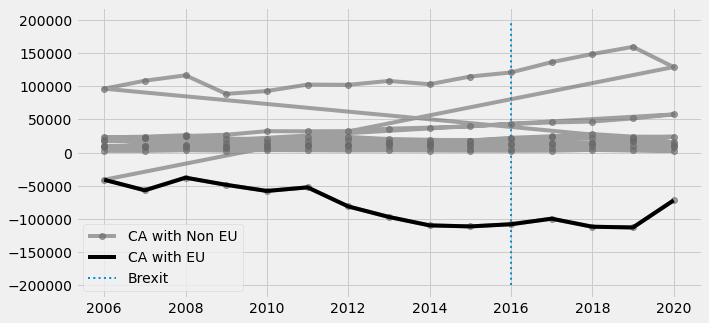

In [87]:
visulaize_origianl('EU','CA', data_c)

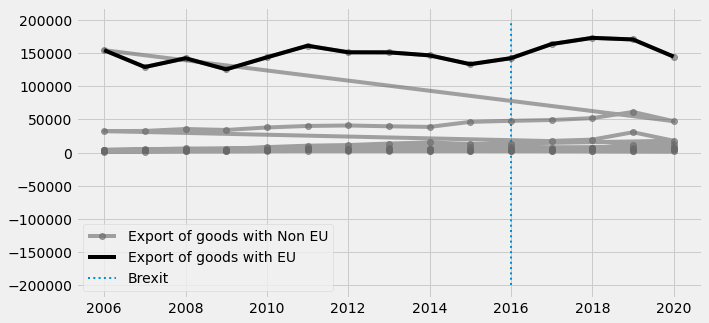

In [88]:
visulaize_origianl('EU','Export of goods', data_g)


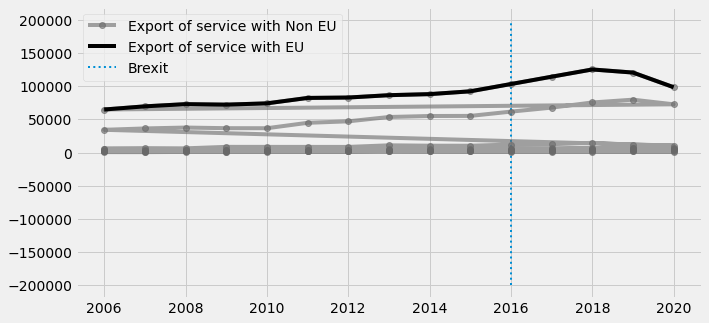

In [89]:
visulaize_origianl('EU','Export of service', data_s)

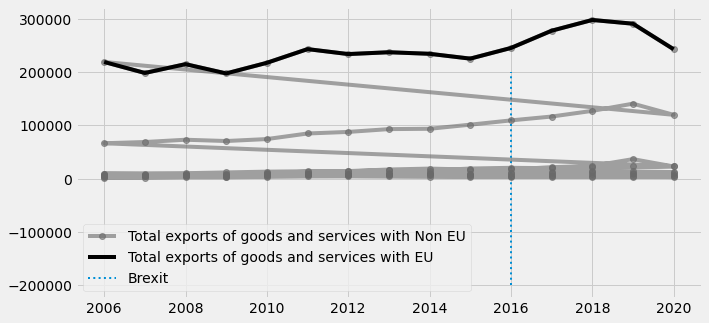

In [90]:
visulaize_origianl('EU','Total exports of goods and services', data_g_s)

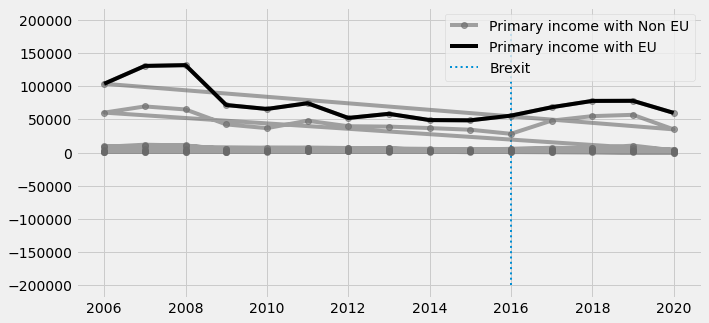

In [91]:
visulaize_origianl('EU','Primary income', data_primary)

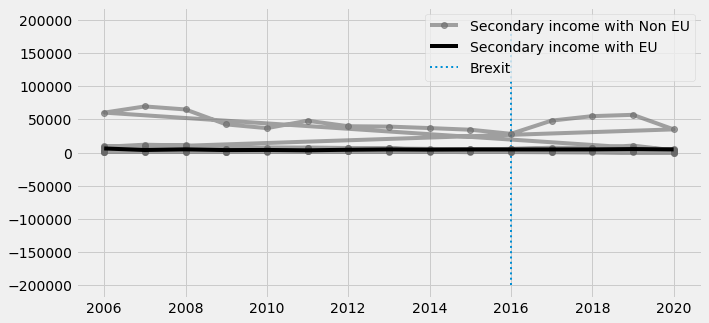

In [92]:
visulaize_origianl('EU','Secondary income', data_secondary)

## 5.2 Dataframe of Difference

### 5.2.1 Synthetic Control Method

In [93]:
synthetic_control_dataframe('EU','CA', data_c)

Sum of weight: 1.0000000000000007
Pre- RMSPE : 1.1915079961260686
Post- RMSPE : 1.1537081779227192


,country,year,CA,Synthetic,Difference
120,EU,2006,-41134,11041.7720,-52175.7720
121,EU,2007,-57047,11570.5873,-68617.5873
122,EU,2008,-37986,12643.1383,-50629.1383
123,EU,2009,-48781,9438.9017,-58219.9017
124,EU,2010,-58028,11329.2928,-69357.2928
125,EU,2011,-52600,12672.6492,-65272.6492
126,EU,2012,-81354,12208.6652,-93562.6652
127,EU,2013,-97270,14371.2140,-111641.2140
128,EU,2014,-109969,12622.2057,-122591.2057
129,EU,2015,-111525,12826.8018,-124351.8018


In [94]:
synthetic_control_dataframe('EU','Export of goods', data_g)

Sum of weight: 1.0000000000000007
Pre- RMSPE : 0.9688334926286077
Post- RMSPE : 0.9600440519287172


,country,year,Export of goods,Synthetic,Difference
120,EU,2006,154412,4057.8898,150354.1102
121,EU,2007,128977,3547.9228,125429.0772
122,EU,2008,142223,3832.9842,138390.0158
123,EU,2009,125524,3899.3754,121624.6246
124,EU,2010,143585,4725.8404,138859.1596
125,EU,2011,161116,5437.3890,155678.6110
126,EU,2012,151187,4750.4484,146436.5516
127,EU,2013,151099,4559.9102,146539.0898
128,EU,2014,146583,4468.3438,142114.6562
129,EU,2015,133260,4549.1432,128710.8568


In [95]:
synthetic_control_dataframe('EU','Export of service', data_s)

Sum of weight: 1.0000000000000018
Pre- RMSPE : 0.7336089053289315
Post- RMSPE : 0.6929995660759269


,country,year,Export of service,Synthetic,Difference
120,EU,2006,64880,16376.8711,48503.1289
121,EU,2007,69637,17361.6964,52275.3036
122,EU,2008,72965,18014.5288,54950.4712
123,EU,2009,72215,17672.0134,54542.9866
124,EU,2010,74149,17801.2739,56347.7261
125,EU,2011,82334,21583.2731,60750.7269
126,EU,2012,82942,22488.0444,60453.9556
127,EU,2013,86476,25659.1008,60816.8992
128,EU,2014,88072,26345.5406,61726.4594
129,EU,2015,92310,26295.2883,66014.7117


In [96]:
synthetic_control_dataframe('EU','Total exports of goods and services', data_g_s)

Sum of weight: 1.0000000000000018
Pre- RMSPE : 0.8195697314307866
Post- RMSPE : 0.7797292617987392


,country,year,Total exports of goods and services,Synthetic,Difference
120,EU,2006,219292,32426.0720,186865.9280
121,EU,2007,198614,33273.3930,165340.6070
122,EU,2008,215188,35291.6023,179896.3977
123,EU,2009,197739,34321.6569,163417.3431
124,EU,2010,217734,36500.5283,181233.4717
125,EU,2011,243450,41641.1962,201808.8038
126,EU,2012,234129,42583.8856,191545.1144
127,EU,2013,237575,45139.2184,192435.7816
128,EU,2014,234655,45342.9760,189312.0240
129,EU,2015,225570,48540.5274,177029.4726


In [97]:
synthetic_control_dataframe('EU','Primary income', data_primary)

Sum of weight: 1.0000000000000007
Pre- RMSPE : 0.9604662783984331
Post- RMSPE : 0.949913368940628


,country,year,Primary income,Synthetic,Difference
120,EU,2006,103730,5092.7108,98637.2892
121,EU,2007,130643,6271.3715,124371.6285
122,EU,2008,131807,5705.0508,126101.9492
123,EU,2009,71650,2285.7216,69364.2784
124,EU,2010,65688,2506.2709,63181.7291
125,EU,2011,74363,2135.2165,72227.7835
126,EU,2012,52141,2268.8347,49872.1653
127,EU,2013,58360,2093.0468,56266.9532
128,EU,2014,48924,1834.6976,47089.3024
129,EU,2015,48563,854.2158,47708.7842


In [98]:
synthetic_control_dataframe('EU','Secondary income', data_secondary)

Sum of weight: 1.0000000000000007
Pre- RMSPE : 0.47305937933683523
Post- RMSPE : 0.3666889701650724


,country,year,Secondary income,Synthetic,Difference
120,EU,2006,6104,5092.7108,1011.2892
121,EU,2007,3769,6271.3715,-2502.3715
122,EU,2008,4753,5705.0508,-952.0508
123,EU,2009,3630,2285.7216,1344.2784
124,EU,2010,3856,2506.2709,1349.7291
125,EU,2011,3320,2135.2165,1184.7835
126,EU,2012,4135,2268.8347,1866.1653
127,EU,2013,4657,2093.0468,2563.9532
128,EU,2014,4360,1834.6976,2525.3024
129,EU,2015,4571,854.2158,3716.7842


5.2.1 Augmented Synthetic Control Method

In [99]:
agumented_synthetic_control_dataframe('EU','CA', data_c)

Pre- RMSPE : 0.09143213457135628
Post- RMSPE : 0.8786797869257832


,country,year,CA,ASCM,Difference
120,EU,2006,-41134,-35015.539107,-6118.460893
121,EU,2007,-57047,-56858.649102,-188.350898
122,EU,2008,-37986,-41903.152109,3917.152109
123,EU,2009,-48781,-52989.508633,4208.508633
124,EU,2010,-58028,-50700.022361,-7327.977639
125,EU,2011,-52600,-61782.457199,9182.457199
126,EU,2012,-81354,-75954.920908,-5399.079092
127,EU,2013,-97270,-99664.934553,2394.934553
128,EU,2014,-109969,-109641.252569,-327.747431
129,EU,2015,-111525,-109653.322074,-1871.677926


In [100]:
agumented_synthetic_control_dataframe('EU','Export of goods', data_g)

Pre- RMSPE : 0.028230018763373377
Post- RMSPE : 0.17990627088601535


,country,year,Export of goods,ASCM,Difference
120,EU,2006,154412,149420.061227,4991.938773
121,EU,2007,128977,130650.867377,-1673.867377
122,EU,2008,142223,145836.851802,-3613.851802
123,EU,2009,125524,125383.092643,140.907357
124,EU,2010,143585,140148.904808,3436.095192
125,EU,2011,161116,161222.160820,-106.160820
126,EU,2012,151187,153761.807707,-2574.807707
127,EU,2013,151099,153263.941590,-2164.941590
128,EU,2014,146583,142082.131855,4500.868145
129,EU,2015,133260,127317.709348,5942.290652


In [101]:
agumented_synthetic_control_dataframe('EU','Export of service', data_s)

Pre- RMSPE : 0.04354491439776053
Post- RMSPE : 0.20143573792819763


,country,year,Export of service,ASCM,Difference
120,EU,2006,64880,62522.514283,2357.485717
121,EU,2007,69637,71673.975223,-2036.975223
122,EU,2008,72965,69076.293459,3888.706541
123,EU,2009,72215,65820.222328,6394.777672
124,EU,2010,74149,76176.038575,-2027.038575
125,EU,2011,82334,79680.505178,2653.494822
126,EU,2012,82942,82832.173351,109.826649
127,EU,2013,86476,89693.976007,-3217.976007
128,EU,2014,88072,92987.399701,-4915.399701
129,EU,2015,92310,89288.341030,3021.658970


In [102]:
agumented_synthetic_control_dataframe('EU','Total exports of goods and services', data_g_s)

Pre- RMSPE : 0.014002556926980323
Post- RMSPE : 0.0656279953007595


,country,year,Total exports of goods and services,ASCM,Difference
120,EU,2006,219292,217979.959479,1312.040521
121,EU,2007,198614,203915.013333,-5301.013333
122,EU,2008,215188,209504.231012,5683.768988
123,EU,2009,197739,198972.466928,-1233.466928
124,EU,2010,217734,213604.540662,4129.459338
125,EU,2011,243450,246660.064842,-3210.064842
126,EU,2012,234129,234517.797109,-388.797109
127,EU,2013,237575,239778.756783,-2203.756783
128,EU,2014,234655,233033.828400,1621.171600
129,EU,2015,225570,225803.508307,-233.508307


In [103]:
agumented_synthetic_control_dataframe('EU','Primary income', data_primary)

Pre- RMSPE : 0.037790306930140814
Post- RMSPE : 0.45126438936949687


,country,year,Primary income,ASCM,Difference
120,EU,2006,103730,110643.797846,-6913.797846
121,EU,2007,130643,131768.511891,-1125.511891
122,EU,2008,131807,124537.029621,7269.970379
123,EU,2009,71650,67611.090554,4038.909446
124,EU,2010,65688,65476.480773,211.519227
125,EU,2011,74363,76579.839305,-2216.839305
126,EU,2012,52141,50248.432271,1892.567729
127,EU,2013,58360,61209.152959,-2849.152959
128,EU,2014,48924,49358.947837,-434.947837
129,EU,2015,48563,47963.819670,599.180330


In [104]:
agumented_synthetic_control_dataframe('EU','Secondary income', data_secondary)

Pre- RMSPE : 0.1029581136563194
Post- RMSPE : 0.29460978926401254


,country,year,Secondary income,ASCM,Difference
120,EU,2006,6104,4880.220091,1223.779909
121,EU,2007,3769,4238.749153,-469.749153
122,EU,2008,4753,5489.470523,-736.470523
123,EU,2009,3630,3494.681223,135.318777
124,EU,2010,3856,3481.981600,374.018400
125,EU,2011,3320,3335.640136,-15.640136
126,EU,2012,4135,3963.194395,171.805605
127,EU,2013,4657,4889.204621,-232.204621
128,EU,2014,4360,4948.468461,-588.468461
129,EU,2015,4571,4392.675048,178.324952


## 5.3 Viusalization

5.3.1 Synthetic Control Method

Sum of weight: 1.0000000000000007


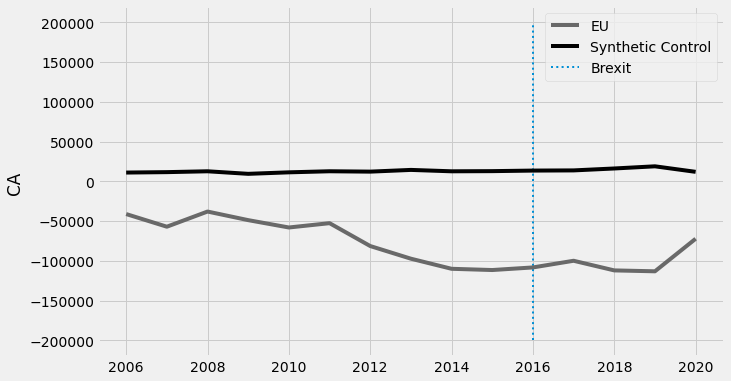

In [105]:
synthetic_plot('EU','CA', data_c)

Sum of weight: 1.0000000000000007


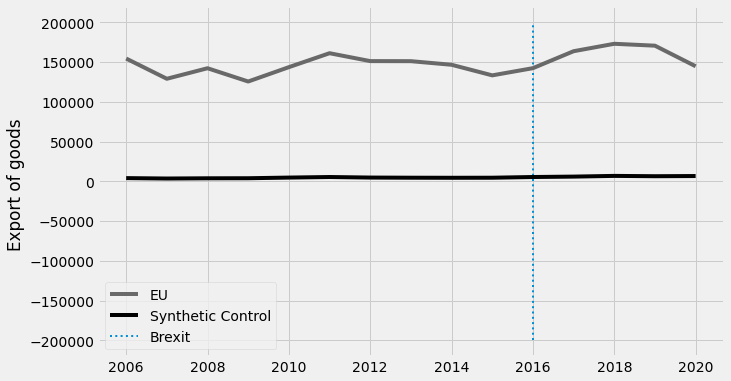

In [106]:
synthetic_plot('EU','Export of goods', data_g)

Sum of weight: 1.0000000000000018


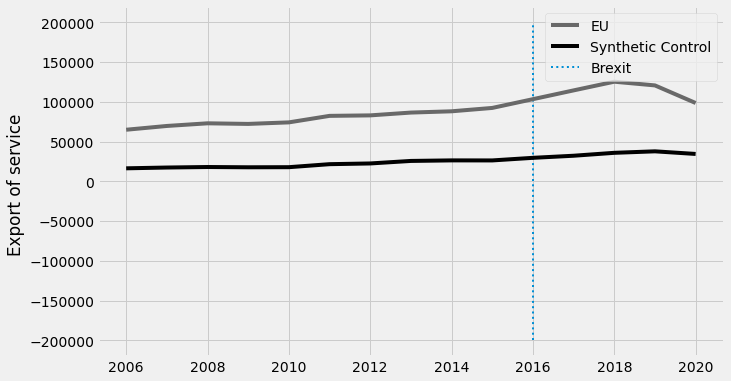

In [107]:
synthetic_plot('EU','Export of service', data_s)

Sum of weight: 1.0000000000000018


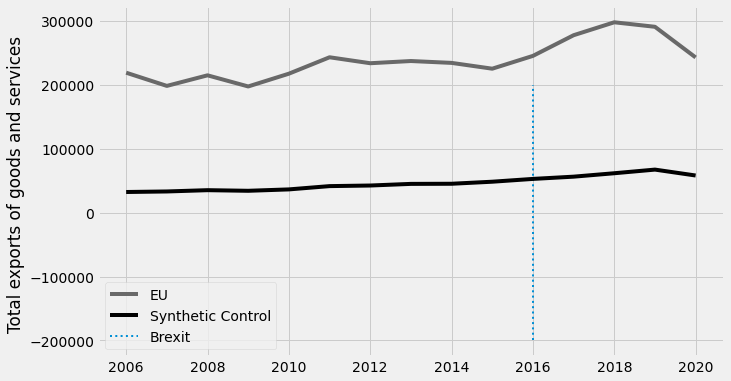

In [108]:
synthetic_plot('EU','Total exports of goods and services', data_g_s)

Sum of weight: 1.0000000000000007


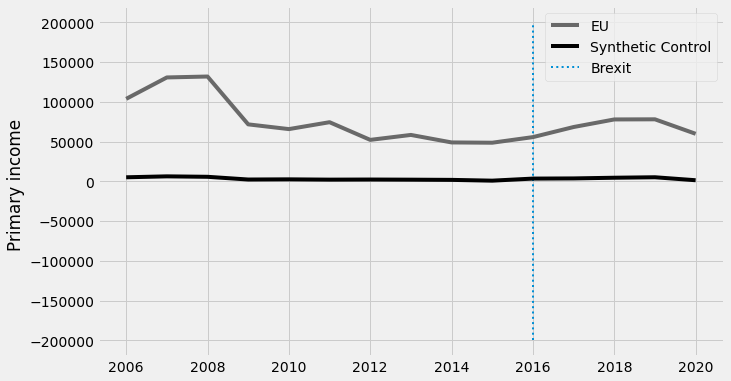

In [109]:
synthetic_plot('EU','Primary income', data_primary)

Sum of weight: 1.0000000000000007


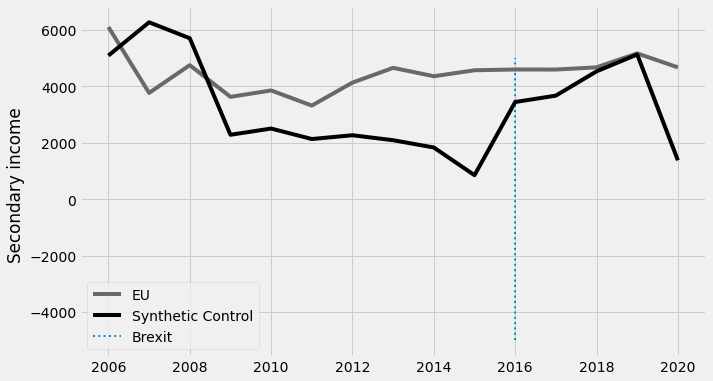

In [110]:
synthetic_plot_magnified('EU','Secondary income', data_secondary)

### 5.3.2 Augmented Synthetic Control Method

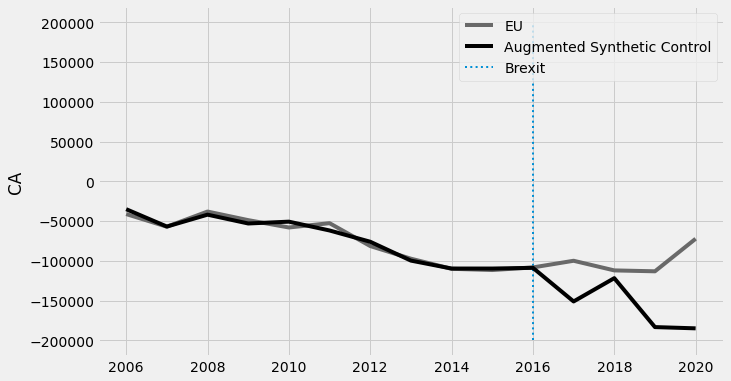

In [111]:
agumented_synthetic_control_visualize('EU','CA', data_c)

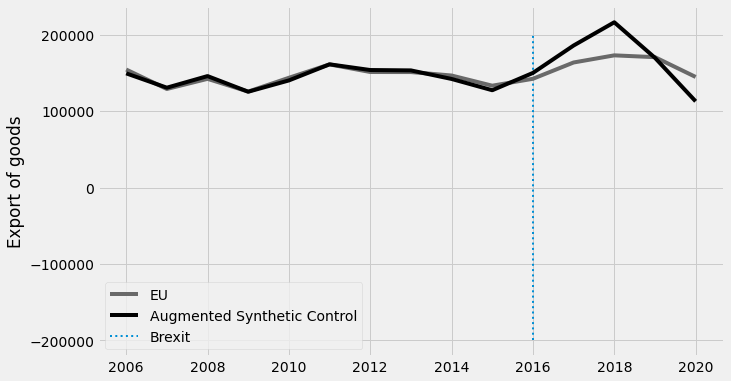

In [112]:
agumented_synthetic_control_visualize('EU','Export of goods', data_g)

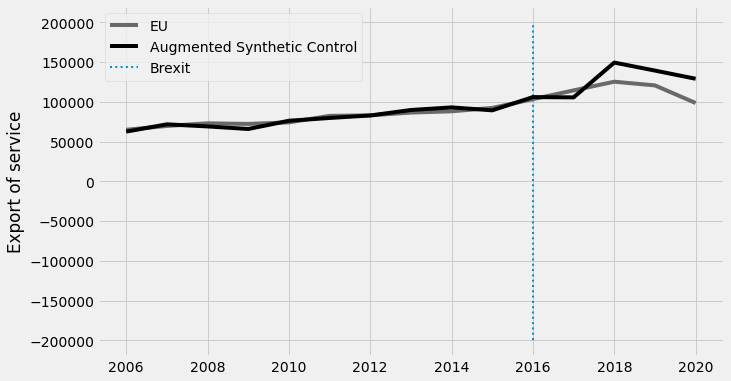

In [113]:
agumented_synthetic_control_visualize('EU','Export of service', data_s)

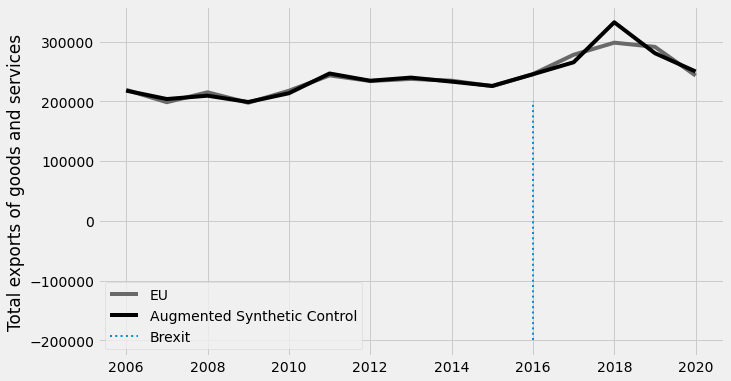

In [114]:
agumented_synthetic_control_visualize('EU','Total exports of goods and services', data_g_s)

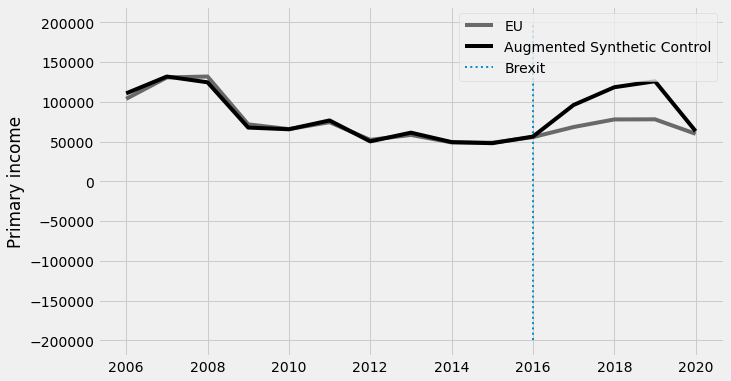

In [115]:
agumented_synthetic_control_visualize('EU','Primary income', data_primary)

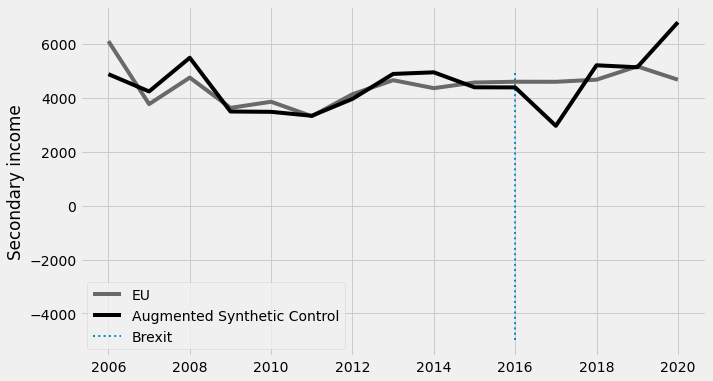

In [116]:
agumented_synthetic_control_visualize_magnified('EU','Secondary income', data_secondary)

# 6. Robust analysis

## 6.1 RSMPE table

In [117]:
rmspe_table('CA', data_c)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.04983314343273621

Post- RMSPE : 0.7227080970262515

Ratio Post_RMSPE/Pre_RMSPE :  14.50255888436475

*****************************************************************************************************************************************************************************************************************************************************************************

In [118]:
rmspe_table('Export of goods', data_g)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.13131191174878754

Post- RMSPE : 0.5119766176251027

Ratio Post_RMSPE/Pre_RMSPE :  3.8989350684693695

****************************************************************************************************************************************************************************************************************************************************************************

In [119]:
rmspe_table('Export of service', data_s)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.15472938714950615

Post- RMSPE : 0.5123148824115723

Ratio Post_RMSPE/Pre_RMSPE :  3.3110380119101213

****************************************************************************************************************************************************************************************************************************************************************************

In [120]:
rmspe_table('Total exports of goods and services', data_g_s)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.06344218351102161

Post- RMSPE : 0.30999527306695307

Ratio Post_RMSPE/Pre_RMSPE :  4.88626424740092

*****************************************************************************************************************************************************************************************************************************************************************************

In [121]:
rmspe_table('Primary income', data_primary)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.1540788258107349

Post- RMSPE : 2.0774596559102765

Ratio Post_RMSPE/Pre_RMSPE :  13.48309636304054

******************************************************************************************************************************************************************************************************************************************************************************

In [122]:
rmspe_table('Secondary income', data_secondary)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

Pre- RMSPE : 0.1865206895526279

Post- RMSPE : 1.3429077856033869

Ratio Post_RMSPE/Pre_RMSPE :  7.199779224623108

******************************************************************************************************************************************************************************************************************************************************************************

## 6.1 in place placebo test

### 6.1.1 in-place placebo visulization

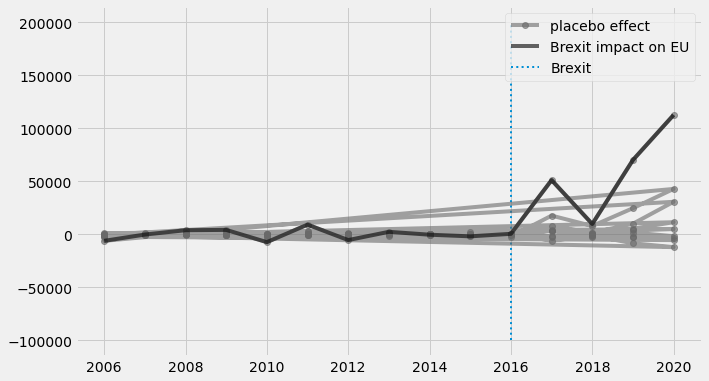

In [123]:
placebo_visualize('EU','CA', data_c)

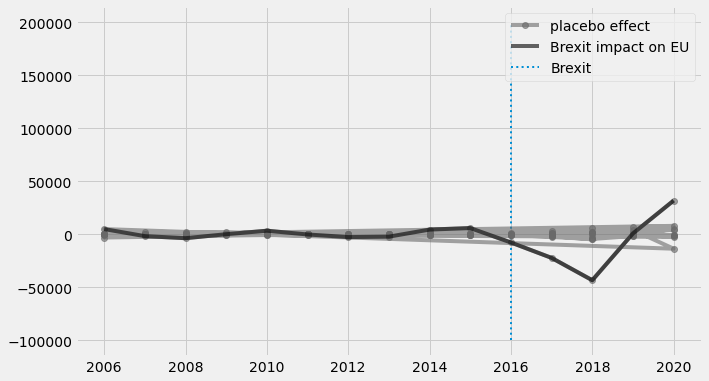

In [124]:
placebo_visualize('EU','Export of goods', data_g)

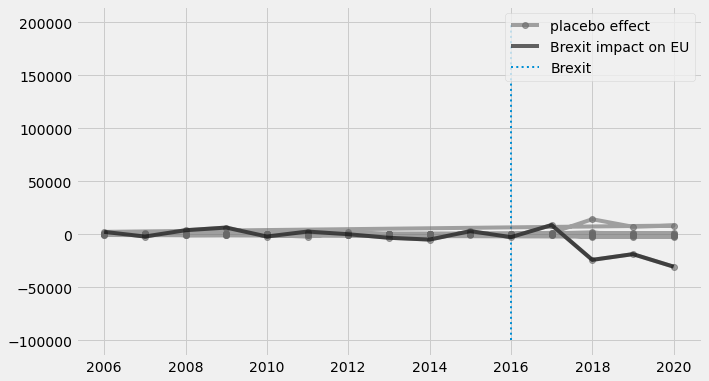

In [125]:
placebo_visualize('EU','Export of service', data_s)

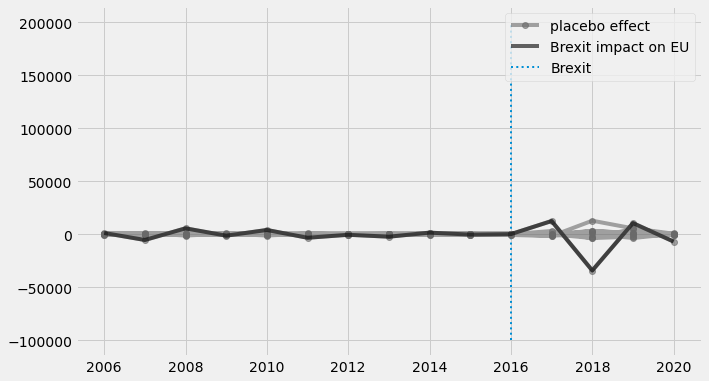

In [126]:
placebo_visualize('EU','Total exports of goods and services', data_g_s)

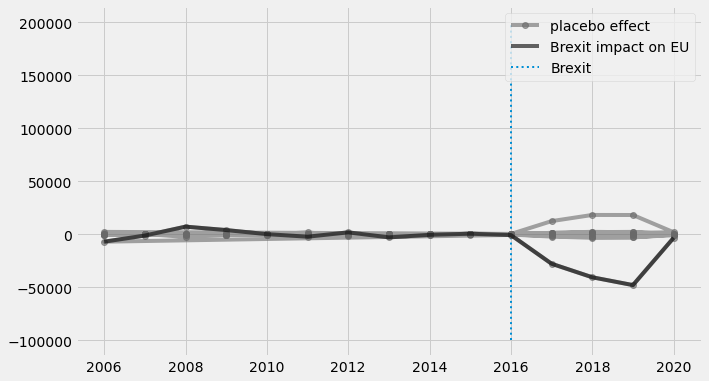

In [127]:
placebo_visualize('EU','Primary income', data_primary)

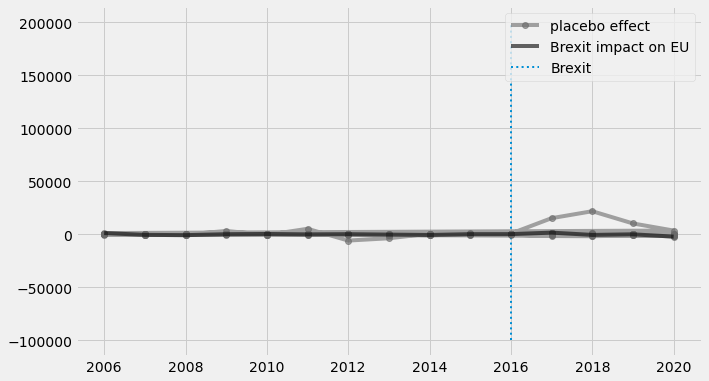

In [128]:
placebo_visualize('EU','Secondary income', data_secondary)

### 6.1.1 p-value of in-place placebo 

In [129]:
p_value_analysis('EU','CA', data_c)

Placebo effects: {'Brazil': -1689.215583080173, 'Canada': -2437.349713377831, 'China': 7919.036763382086, 'India': 3581.2196747642447, 'Japan': -5964.623360305432, 'Russia': 4045.374495481552, 'Switzerland': 3113.393815820964, 'USA': 17670.951170634828}
Brexit Treatment Effect for the Year 2017 (EU): 51155.92070035642
p-value : 0.0


Placebo effects: {'Brazil': -210.59642676010571, 'Canada': -763.9357663555365, 'China': 1497.5563498878546, 'India': 445.1019818093646, 'Japan': -1133.2246036502765, 'Russia': 1127.8933324894024, 'Switzerland': -2346.168588839224, 'USA': 7898.752294219914}
Brexit Treatment Effect for the Year 2018 (EU): 9763.425192982832
p-value : 0.0


Placebo effects: {'Brazil': -2079.365402978825, 'Canada': -2630.836852504959, 'China': 10048.389315167697, 'India': 4027.163746851673, 'Japan': -8442.243808187613, 'Russia': 5419.107710082393, 'Switzerland': 1676.1211306554687, 'USA': 24678.357288418832}
Brexit Treatment Effect for the Year 2019 (EU): 70149.35582784342
p-va

In [130]:
p_value_analysis('EU','Export of goods', data_g)

Placebo effects: {'Brazil': -615.4222646996213, 'Canada': 1030.1697484681472, 'China': -1707.527708689151, 'India': 1032.0648317721207, 'Japan': 632.9939698540229, 'Russia': -1593.7459799968883, 'Switzerland': -2493.4581672777767, 'USA': 2995.4461114808655}
Brexit Treatment Effect for the Year 2017 (EU): -22199.546531978005
p-value : 0.0


Placebo effects: {'Brazil': -922.1913033346295, 'Canada': 2006.7028293146495, 'China': -4756.595639689993, 'India': 2620.4963259317083, 'Japan': 1157.32283675708, 'Russia': -3133.661603675251, 'Switzerland': -4382.606279994463, 'USA': 5855.529680906955}
Brexit Treatment Effect for the Year 2018 (EU): -43260.39892266889
p-value : 0.0


Placebo effects: {'Brazil': -1595.9353836694413, 'Canada': -79.26605153583023, 'China': 6521.208377088908, 'India': 58.416478165723674, 'Japan': -188.7218622800092, 'Russia': 1050.7942984958945, 'Switzerland': -1549.0990637204086, 'USA': 4134.918696028049}
Brexit Treatment Effect for the Year 2019 (EU): 819.560047061357

In [131]:
p_value_analysis('EU','Export of service', data_s)

Placebo effects: {'Brazil': 145.4860424671656, 'Canada': -362.5640500928648, 'China': 49.41484877552102, 'India': -312.4056492704826, 'Japan': -45.92522546811597, 'Russia': 55.89486588602995, 'Switzerland': 954.8912279639153, 'USA': 1449.8681639130518}
Brexit Treatment Effect for the Year 2017 (EU): 8787.495504509876
p-value : 0.0


Placebo effects: {'Brazil': 191.60259781770583, 'Canada': -607.5402550256204, 'China': -1767.9054521303742, 'India': 1392.535062012409, 'Japan': -2643.8998688178854, 'Russia': -1571.781218274642, 'Switzerland': 1936.7345777067385, 'USA': 14282.768506111337}
Brexit Treatment Effect for the Year 2018 (EU): -24051.87537064182
p-value : 0.0


Placebo effects: {'Brazil': -897.5483694489667, 'Canada': 202.06410141963352, 'China': -297.32647950657065, 'India': 988.8831192976377, 'Japan': -1658.4536247202414, 'Russia': -1021.2201848685804, 'Switzerland': -2119.1588125316557, 'USA': 7138.414759579275}
Brexit Treatment Effect for the Year 2019 (EU): -18651.9486500799

In [132]:
p_value_analysis('EU','Total exports of goods and services', data_g_s)

Placebo effects: {'Brazil': -556.5248162110256, 'Canada': -222.26720880715948, 'China': 3180.211341669725, 'India': -610.1321373108076, 'Japan': -1229.3879648702405, 'Russia': 98.95650465837753, 'Switzerland': 146.9030854359953, 'USA': -1584.1827465899696}
Brexit Treatment Effect for the Year 2017 (EU): 12576.569364044059
p-value : 0.0


Placebo effects: {'Brazil': 1946.2080725760097, 'Canada': 3407.646250267946, 'China': -3776.722842696381, 'India': 3170.86172281612, 'Japan': 514.7097397113776, 'Russia': -2127.7027184844846, 'Switzerland': -3504.457021101556, 'USA': 12873.993121162523}
Brexit Treatment Effect for the Year 2018 (EU): -34094.0653418249
p-value : 0.0


Placebo effects: {'Brazil': 237.86430853225102, 'Canada': 1073.9843568682772, 'China': 5301.665809011894, 'India': 1002.7386928419837, 'Japan': -3447.223795636699, 'Russia': -1390.8307888702657, 'Switzerland': -2111.0092387330296, 'USA': 5668.084783776023}
Brexit Treatment Effect for the Year 2019 (EU): 10626.220939173887


In [133]:
p_value_analysis('EU','Primary income', data_primary)

Placebo effects: {'Brazil': -1511.5011571041427, 'Canada': 867.4798207441136, 'China': 1402.8709099493926, 'India': -381.93783014598375, 'Japan': -2093.8317818760543, 'Russia': 1410.743131677401, 'Switzerland': 1066.0602113641153, 'USA': 12482.46575080938}
Brexit Treatment Effect for the Year 2017 (EU): -27713.819682197587
p-value : 0.0


Placebo effects: {'Brazil': -2616.18245509121, 'Canada': 2074.624182894845, 'China': 1450.8749797980781, 'India': -83.87122508357925, 'Japan': -3225.179314855777, 'Russia': 2399.252721360759, 'Switzerland': -1221.958669694518, 'USA': 18307.005070071857}
Brexit Treatment Effect for the Year 2018 (EU): -40475.38231973509
p-value : 0.0


Placebo effects: {'Brazil': -2732.5580805637687, 'Canada': 2345.7702132155346, 'China': 612.8507713798085, 'India': 300.46267398103373, 'Japan': -2937.340530174766, 'Russia': 1884.6498400982064, 'Switzerland': -719.70465454642, 'USA': 18247.198078215064}
Brexit Treatment Effect for the Year 2019 (EU): -47855.41800433742


In [134]:
p_value_analysis('EU','Secondary income', data_secondary)

Placebo effects: {'Brazil': -83.24277785528648, 'Canada': -549.6370306013291, 'China': 1288.332545967516, 'India': -475.12837153254804, 'Japan': -1583.7878017776238, 'Russia': 963.5111113583625, 'Switzerland': 1538.3872962605874, 'USA': 15269.899321825847}
Brexit Treatment Effect for the Year 2017 (EU): 1634.4106699639592
p-value : 0.125


Placebo effects: {'Brazil': -1520.560760851739, 'Canada': 733.5453331546469, 'China': 956.8617250833104, 'India': -91.42572245123438, 'Japan': -1753.14600702793, 'Russia': 1380.2741411221655, 'Switzerland': -1033.9881670248506, 'USA': 21817.60078945521}
Brexit Treatment Effect for the Year 2018 (EU): -534.7387803354641
p-value : 0.875


Placebo effects: {'Brazil': -997.0590122886019, 'Canada': 638.289943817319, 'China': 238.76803474437202, 'India': 53.90061272100593, 'Japan': -1059.5740831883268, 'Russia': 573.5773579405559, 'Switzerland': -411.15661580647793, 'USA': 10287.017894509467}
Brexit Treatment Effect for the Year 2019 (EU): 32.8825865011522

In [135]:
## 6.2 limitation of donor pool


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 25.67522707  12.67622579  -1.84132778 -10.04537644   6.07869015
  -7.34290678  -1.16131589  -1.64635586]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [12.96135524 -1.840265   -3.91510323  8.44974577 -7.95732341  0.9623391
 -2.38361466]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-2.04122198  0.34876032  6.63310157 -4.10779583  0.33491518 -1.22535161]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-5.11795672  7.20904093 -1.24017469  0.21459579 -1.60033989]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 6.09671687 -1.97323342  4.86741574 -2.6372971 ]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [ 2.72491778  8.11987492 -2.31635848]

Countries: ['Switzerland', 'USA']
Weights: [ 9.21223471 -2.28725351]

Countries: ['USA']
Weights: [-0.70243115]


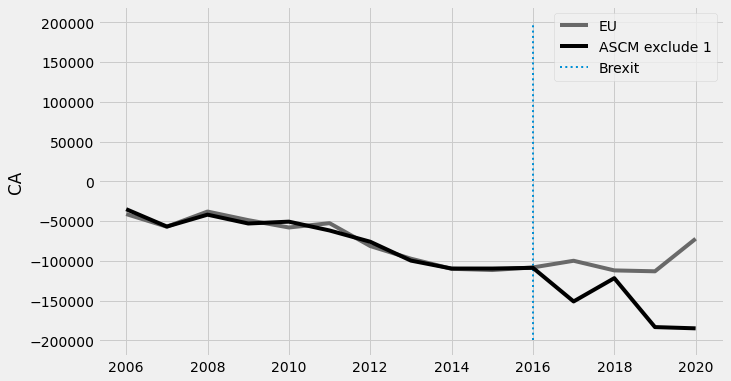

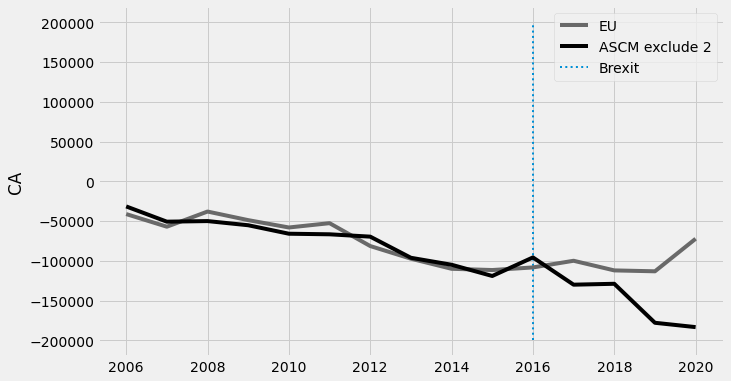

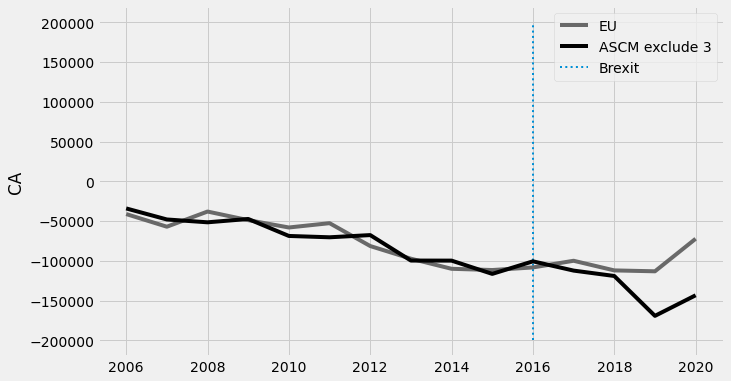

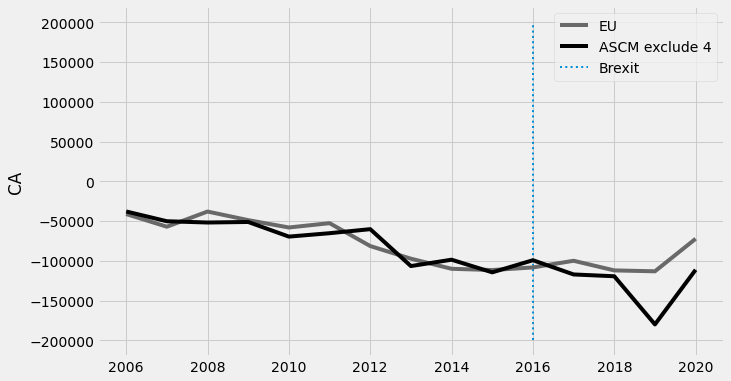

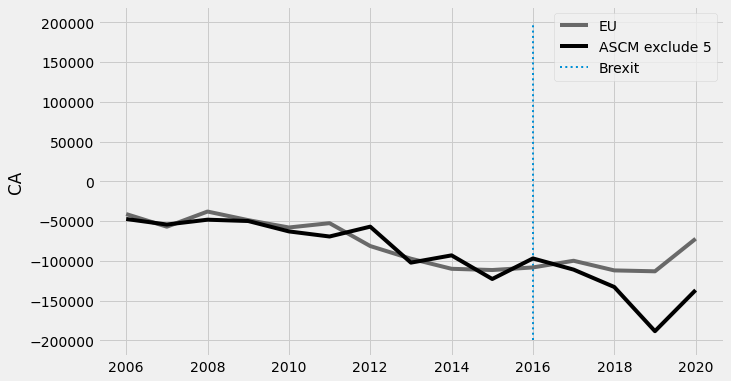

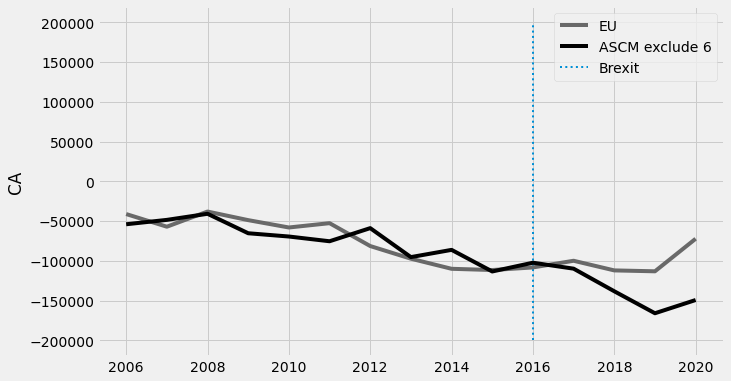

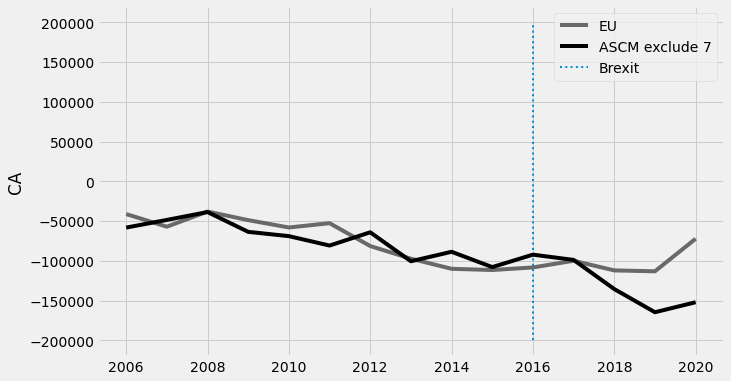

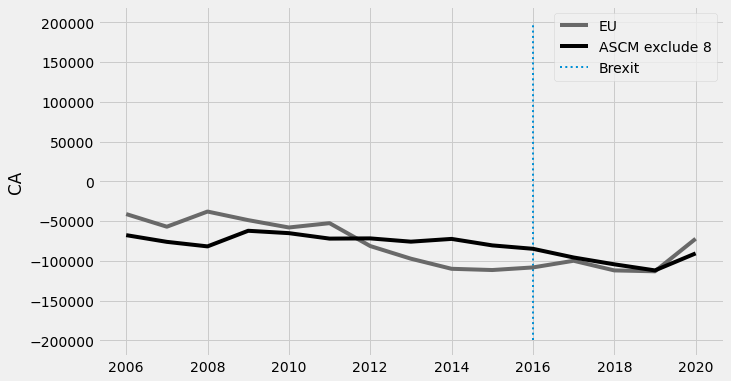

In [136]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','CA', data_c)


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-3.79842718 14.30460213 -3.17213745  5.20621243 25.43198799 -8.11379126
 -4.64372431  1.08174775]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [14.36177509 -3.58320272  4.51401252 26.94502806 -8.79428081 -4.43462646
  0.92456442]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-3.60261925  4.81361357 31.36178935 -5.69983721 -3.7902907   1.53918368]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-0.80490024 23.78132434 -1.03540941 -9.6960766   2.51580504]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [22.44423218 -1.1258432  -9.61590411  2.569455  ]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [  2.02263947 -12.74323996   5.22161565]

Countries: ['Switzerland', 'USA']
Weights: [-13.76657629   5.53861698]

Countries: ['USA']
Weights: [3.66398184]


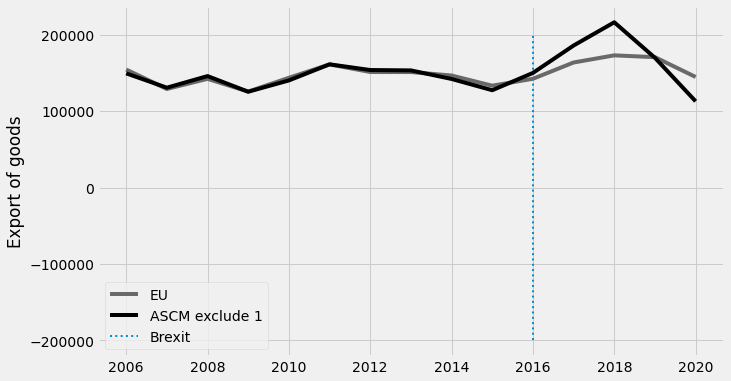

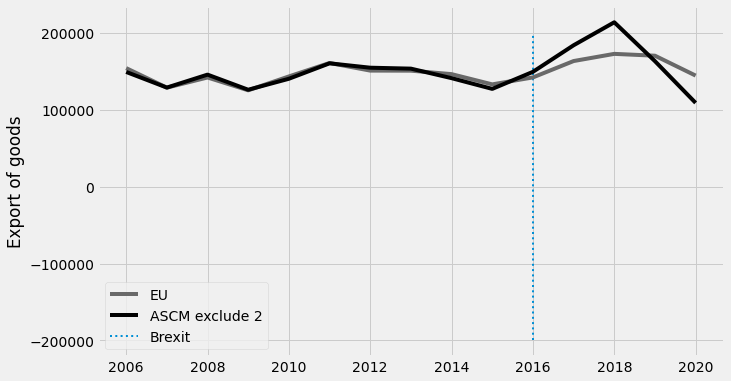

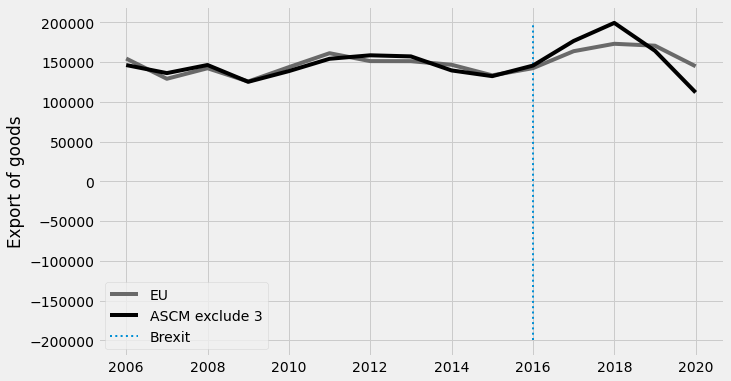

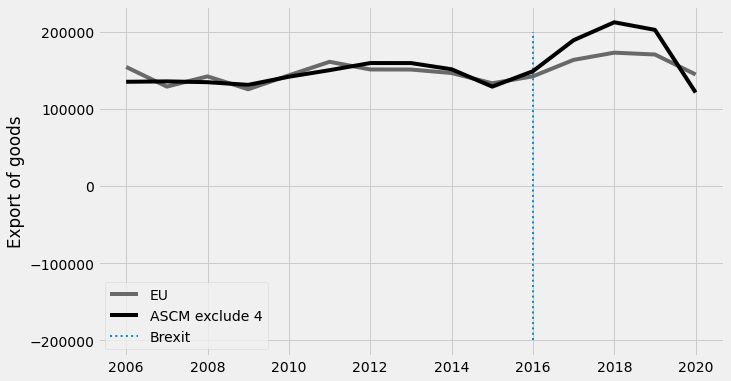

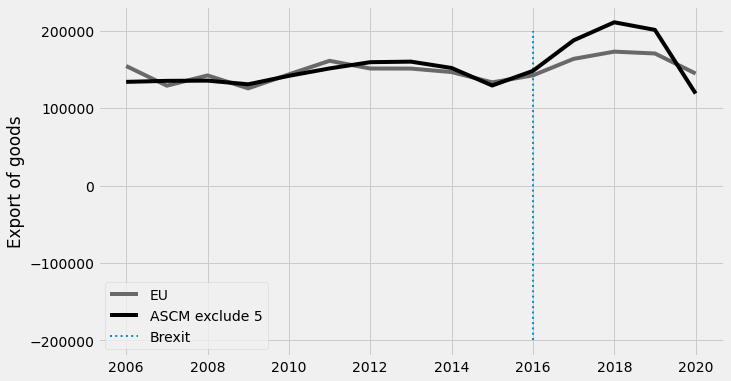

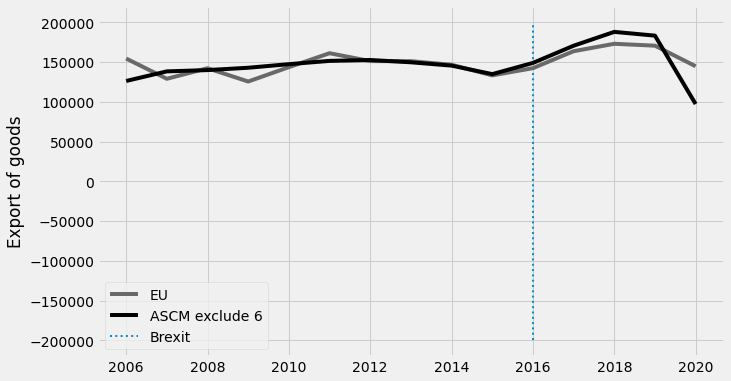

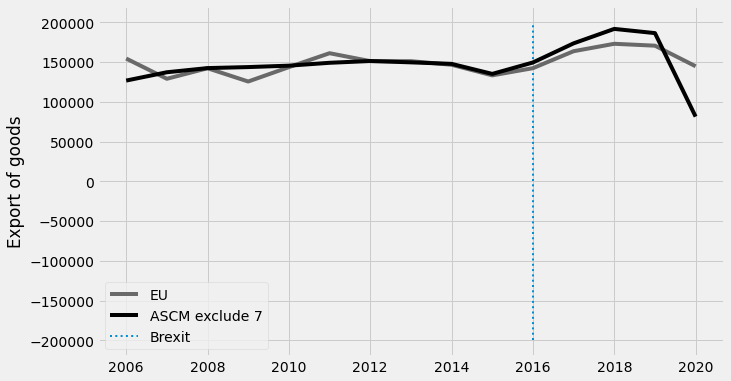

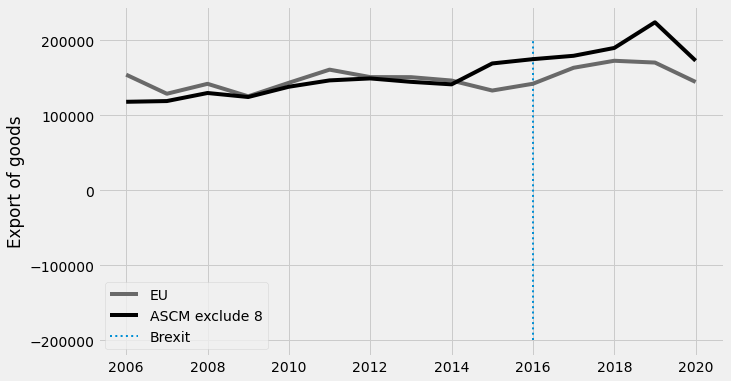

In [137]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Export of goods', data_g)


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ -1.5420218   11.83985668 -11.0011177   19.77776577  -1.3931903
  -8.64369788  -0.8264232    1.31821743]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 10.78116546 -11.98886047  19.7714046   -1.19431026  -9.33015489
  -0.61362375   1.39720353]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-14.96893027  24.01667236  -5.52327304 -10.85535972   1.78004047
   2.30557346]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 7.01636956 -2.48935241  4.81207072  1.75865734  1.14330648]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-0.97894887  8.41027688  2.22149117  1.0679246 ]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [8.06039625 2.14307032 1.00484216]

Countries: ['Switzerland', 'USA']
Weights: [1.4859356  1.47186874]

Countries: ['USA']
Weights: [1.75680242]


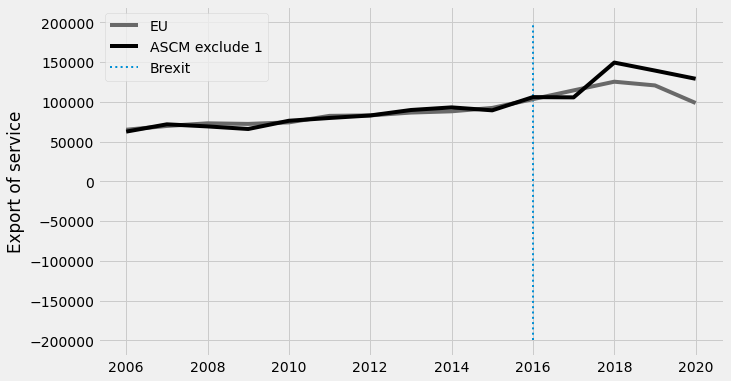

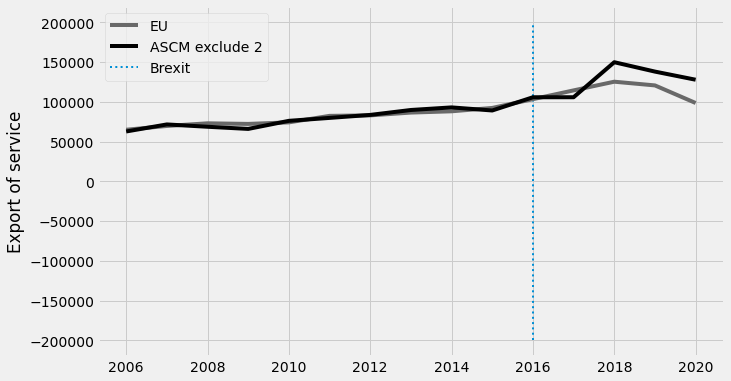

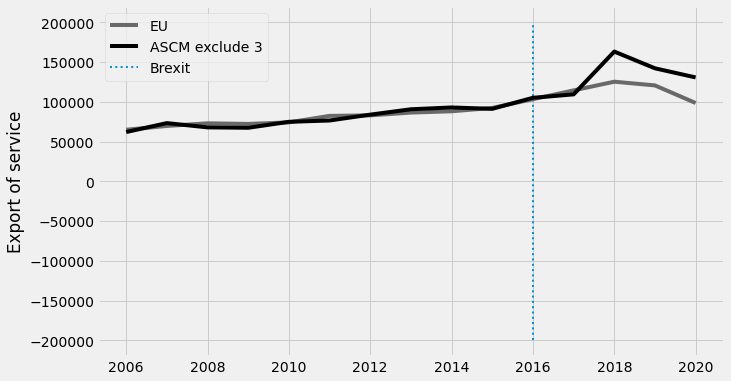

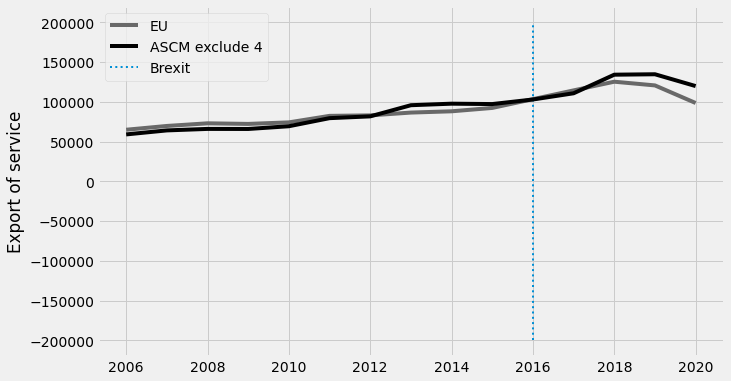

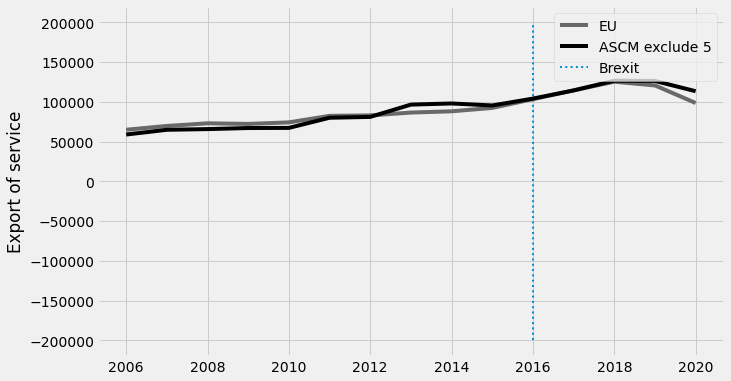

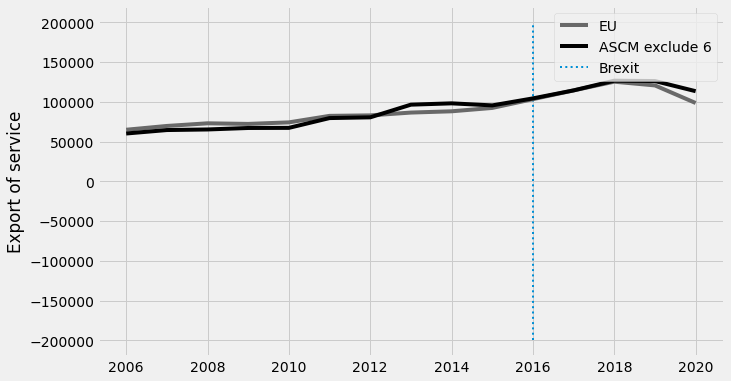

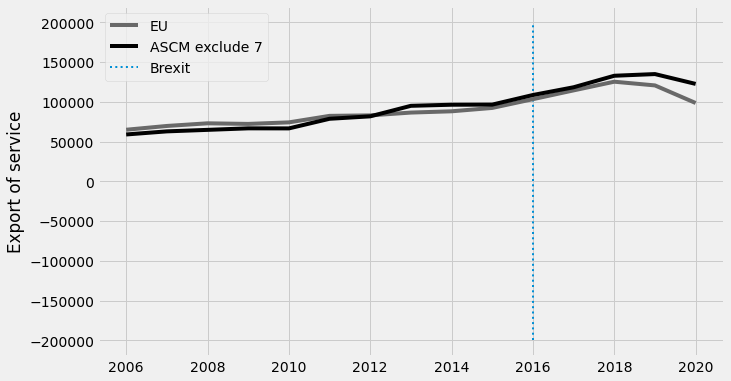

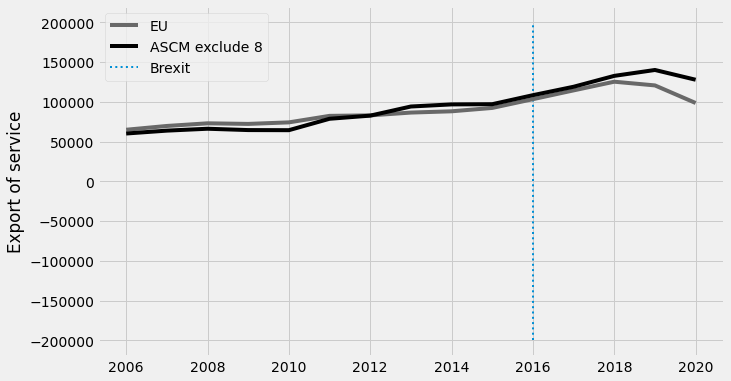

In [138]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Export of service', data_s)


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 11.79647709   9.59436572  -5.14982878  11.93900345   7.90036441
 -15.24692379 -10.66340435   3.07656521]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 9.58524343 -4.84241995  9.97714734  9.11146173 -3.16274987 -4.52440915
  1.73188033]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-6.44113753  8.51869166 12.54566857  5.94454522  1.34293815  1.07251531]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 13.17743993   7.64303769 -13.14434099 -14.91080468   4.14061965]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 12.91656215   4.2052452  -10.54204586   2.79769714]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [  1.95983876 -13.90231655   4.82213751]

Countries: ['Switzerland', 'USA']
Weights: [-14.96160782   5.12098261]

Countries: ['USA']
Weights: [2.6266

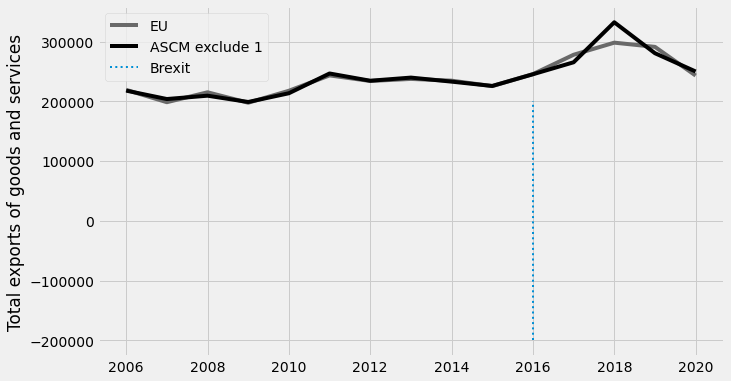

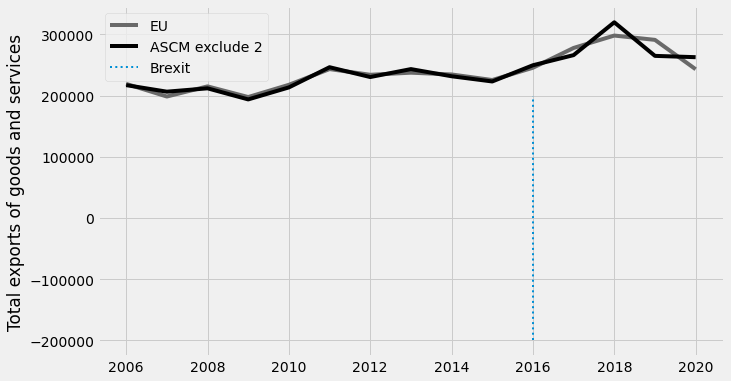

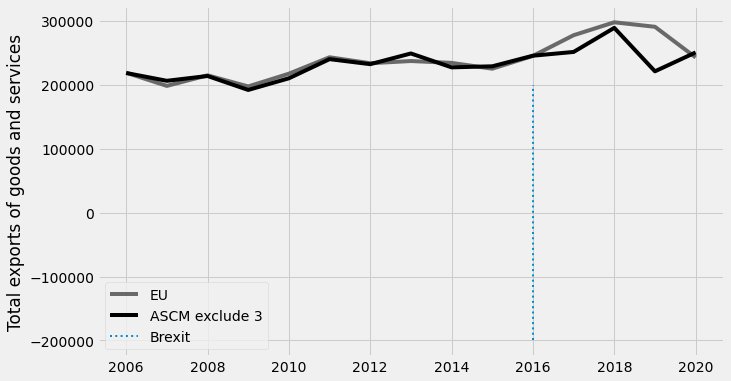

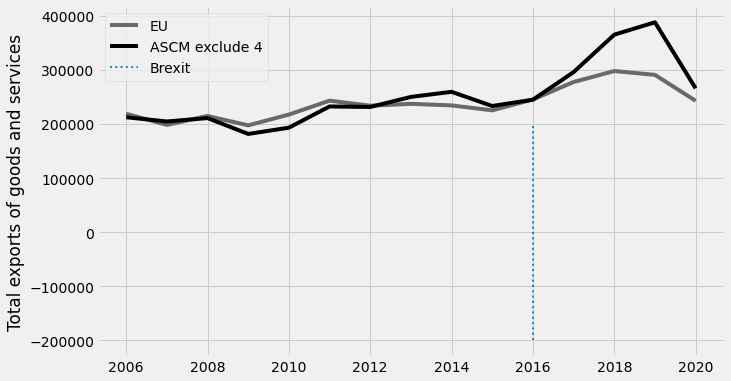

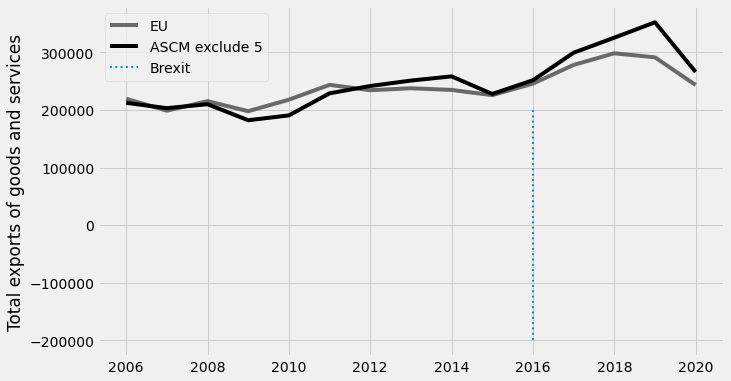

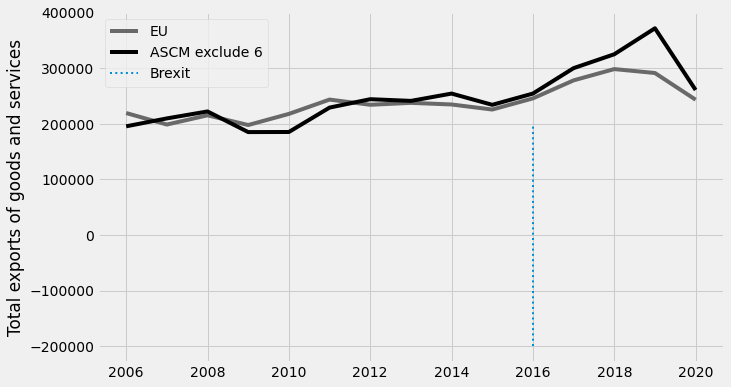

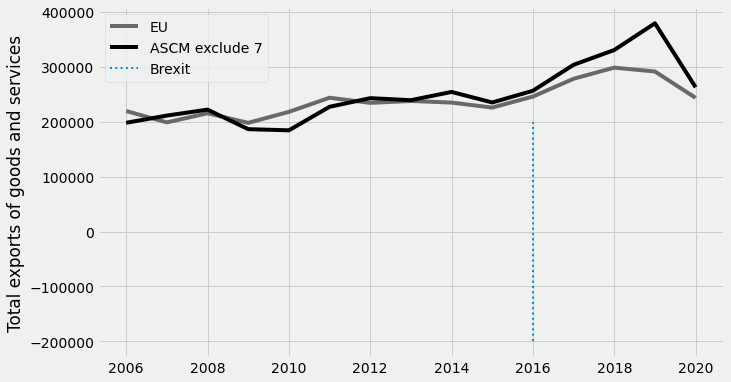

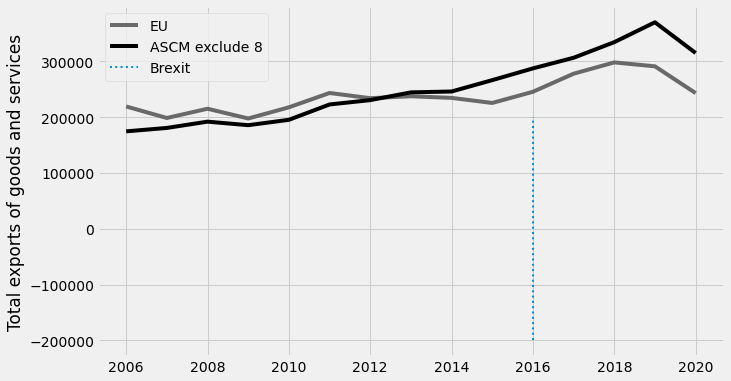

In [139]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Total exports of goods and services', data_g_s)


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-11.72868998   9.40865413   2.06026215   3.98793088  -9.98333349
   9.62036479  -0.1056558    2.34202814]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 8.2078883  -0.32729043 -2.92622294 -3.93945895  0.2745509   1.47930343
  1.68823072]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [  5.06083861 -16.35141435  -1.65376123  -0.60058958   5.42406351
   1.61236449]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-8.83736682  0.94927946 -4.1739721   5.00014223  1.3564174 ]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 2.32578407 -9.80949693  4.68377366  1.1698551 ]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [-9.53842106  5.02089437  1.44833514]

Countries: ['Switzerland', 'USA']
Weights: [4.00657573 1.10334738]

Countries: ['USA']
Weights: [1.72240688]


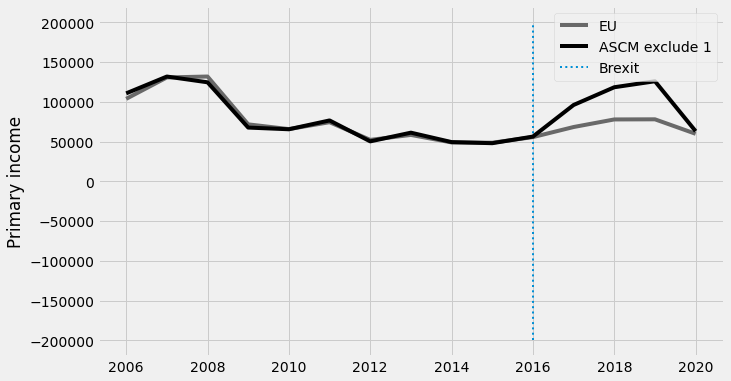

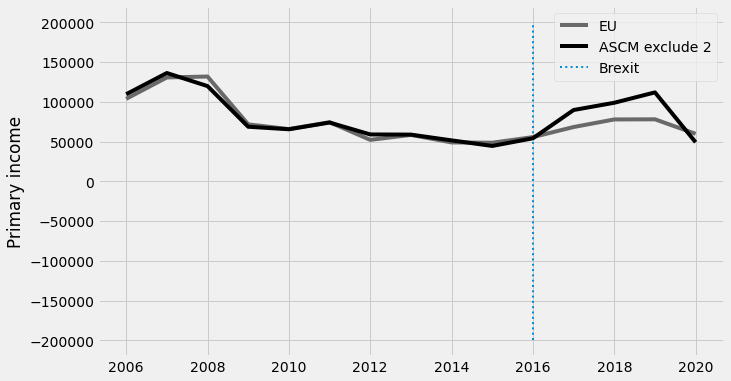

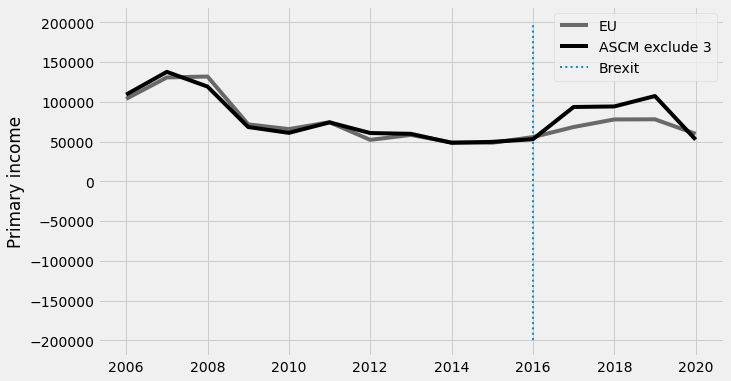

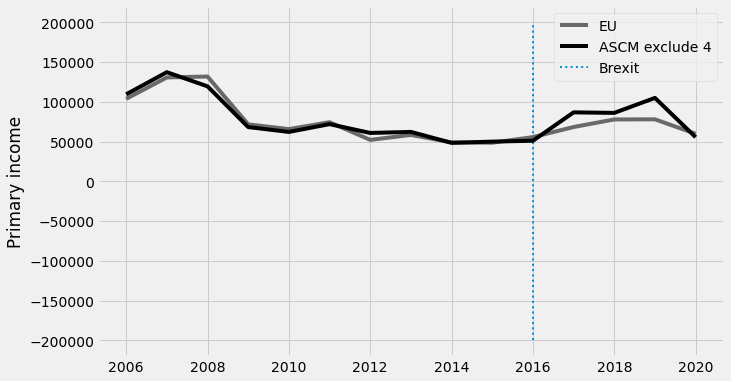

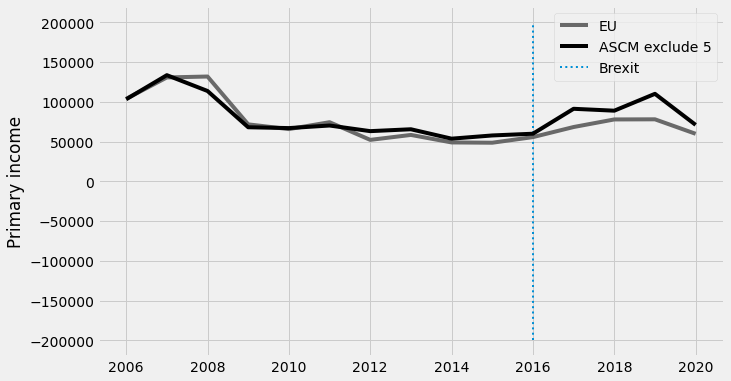

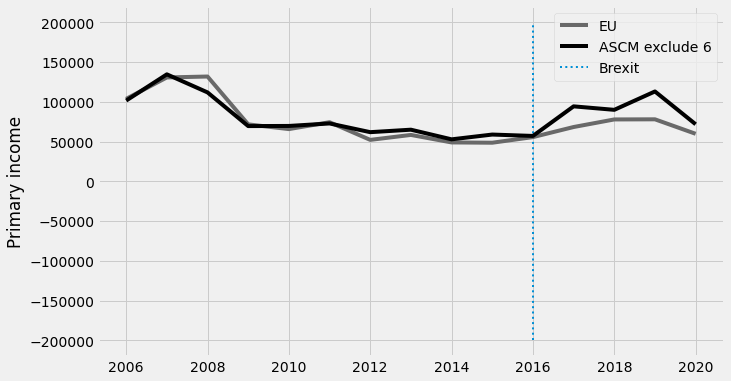

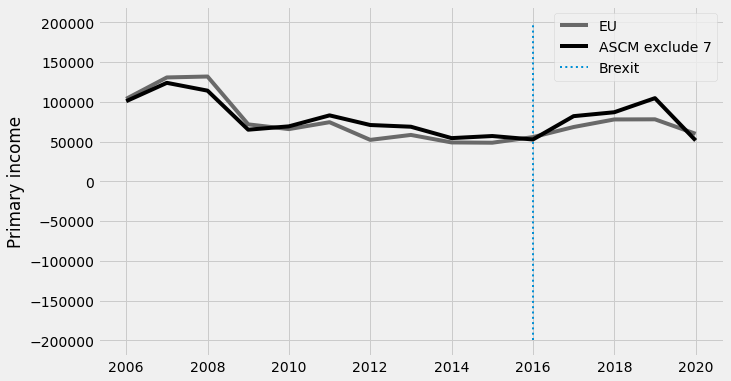

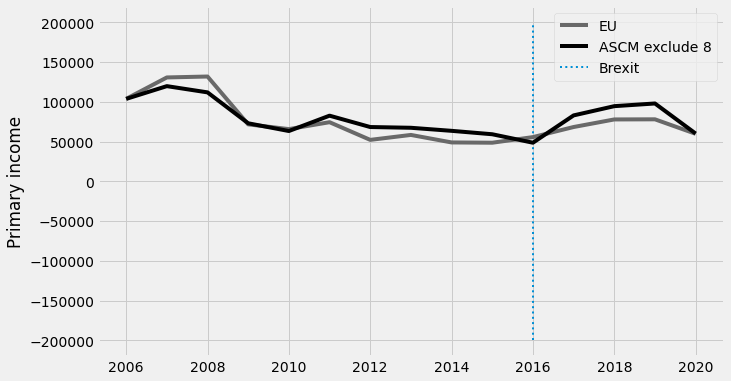

In [140]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Primary income', data_primary)


Countries: ['Brazil', 'Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-0.6993466   0.28924164 -0.91553062  3.80241628  0.9408455  -0.86458064
 -0.65848453 -0.00935223]

Countries: ['Canada', 'China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 0.21764357 -1.05789322  3.39014604  1.3012236  -1.42184348 -0.56397816
 -0.04833621]

Countries: ['China', 'India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [-0.91501948  3.03415841  1.36183206 -1.44504905 -0.45937736 -0.05034791]

Countries: ['India', 'Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 1.67558914  0.89119208 -0.79896746 -0.38273073 -0.00407167]

Countries: ['Japan', 'Russia', 'Switzerland', 'USA']
Weights: [ 0.63020301  0.2695436  -0.32274638  0.03130105]

Countries: ['Russia', 'Switzerland', 'USA']
Weights: [ 0.34299531 -0.23139891  0.10675903]

Countries: ['Switzerland', 'USA']
Weights: [-0.19492468  0.11916456]

Countries: ['USA']
Weights: [0.08904658]


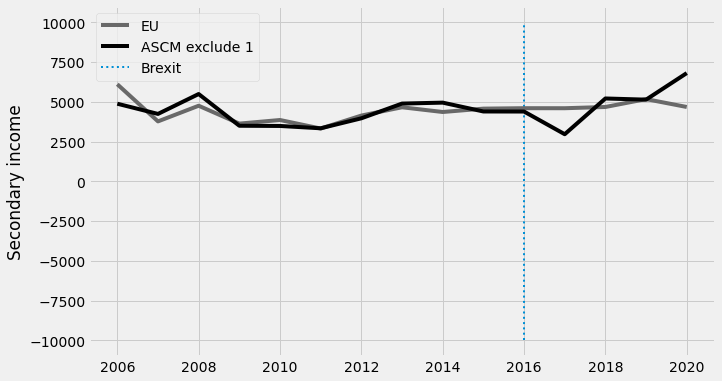

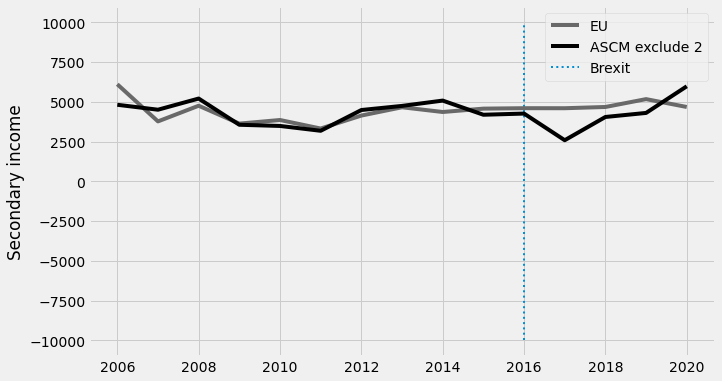

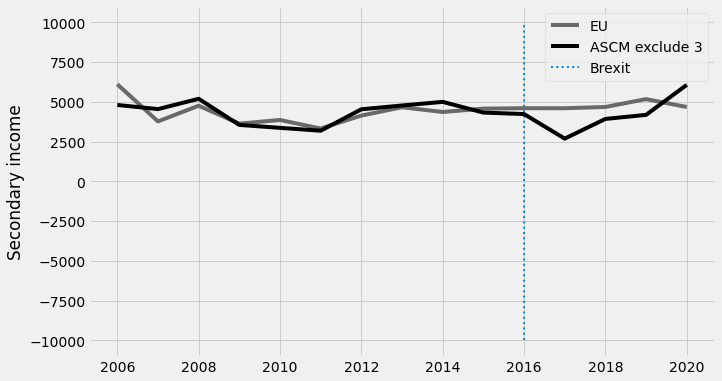

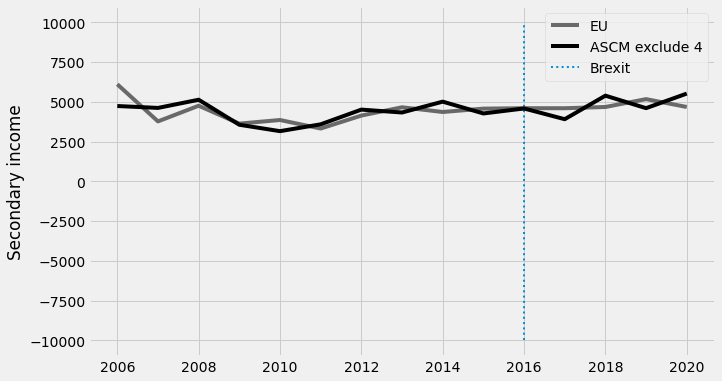

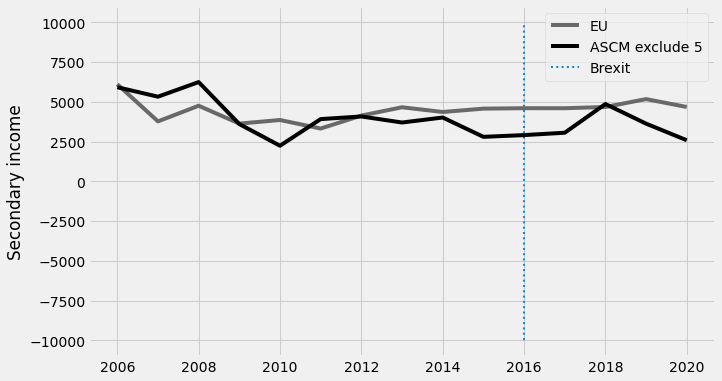

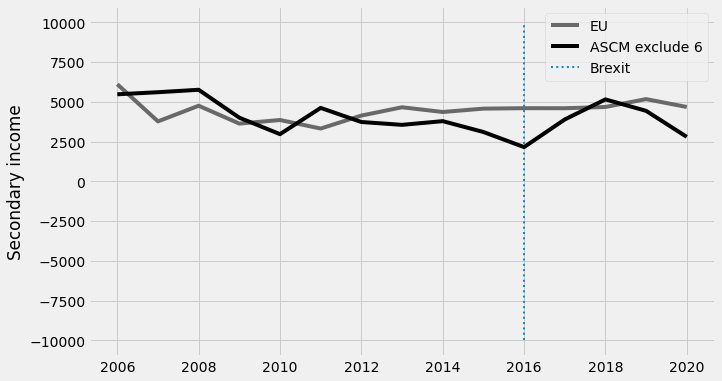

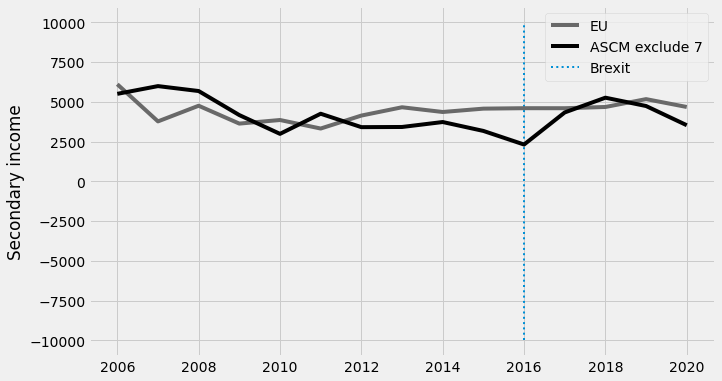

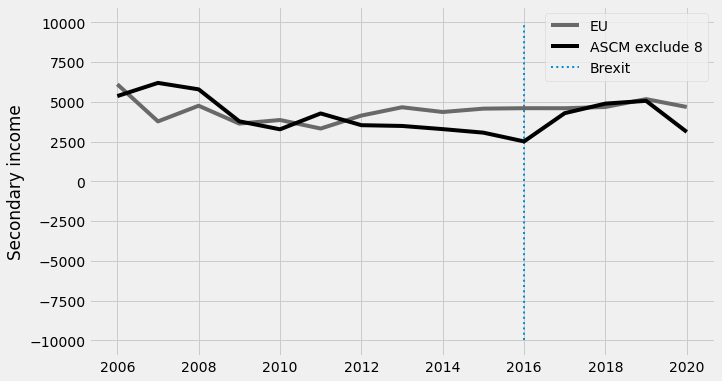

In [141]:
agumented_synthetic_control_visualize_limit_donor_pool_magnified('EU','Secondary income', data_secondary)

adsfadsf
